In [1]:
#export
"""
.. module:: k1lib
"""
from typing import Callable, Iterator, Tuple, Union, Dict, Any, List
from k1lib import isNumeric; import k1lib, contextlib, warnings
import random, math, sys, io, os, numpy as np
import matplotlib.pyplot as plt
try: import torch; hasTorch = True
except: hasTorch = False
__all__ = ["Object", "Range", "Domain", "AutoIncrement", "Wrapper", "Every",
           "RunOnce", "MaxDepth", "MovingAvg", "Absorber",
           "Settings", "settings", "_settings", "UValue", "ConstantPad"]

In [2]:
#export
class Object:
    """Convenience class that acts like :class:`~collections.defaultdict`. You
can use it like a normal object::

    a = k1lib.Object()
    a.b = 3
    print(a.b) # outputs "3"

``__repr__()`` output is pretty nice too:

.. code-block:: text

    <class '__main__.Object'>, with attrs:
    - b

You can instantiate it from a dict::

    a = k1lib.Object.fromDict({"b": 3, "c": 4})
    print(a.c) # outputs "4"

And you can specify a default value, just like defaultdict::

    a = k1lib.Object().withAutoDeclare(lambda: [])
    a.texts.extend(["factorio", "world of warcraft"])
    print(a.texts[0]) # outputs "factorio"
    
.. warning::

    Default values only work with variables that don't start with an
    underscore "_".

Treating it like defaultdict is okay too::

    a = k1lib.Object().withAutoDeclare(lambda: [])
    a["movies"].append("dune")
    print(a.movies[0]) # outputs "dune" """
    def __init__(self): self._defaultValueGenerator = None; self.repr = None
    @staticmethod
    def fromDict(_dict:Dict[str, Any]):
        """Creates an object with attributes from a dictionary"""
        answer = Object(); answer.__dict__.update(_dict); return answer
    @property
    def state(self) -> dict:
        """Essentially ``__dict__``, but only outputs the fields you
defined. If your framework intentionally set some attributes, those
will be reported too, so beware"""
        answer = dict(self.__dict__); del answer["_defaultValueGenerator"]
        del answer["repr"]; return answer
    def withAutoDeclare(self, defaultValueGenerator):
        """Sets this Object up so that if a field doesn't
        exist, it will automatically create it with a
        default value."""
        self._defaultValueGenerator = defaultValueGenerator; return self
    def __getitem__(self, idx): return getattr(self, idx)
    def __setitem__(self, idx, value): setattr(self, idx, value)
    def __iter__(self): yield from self.state.values()
    def __contains__(self, item:str): return item in self.__dict__
    def __getattr__(self, attr):
        if attr.startswith("_"): raise AttributeError()
        if attr == "getdoc": raise AttributeError("This param is used internally in module `IPython.core.oinspect`, so you kinda have to set it specifically yourself instead of relying on auto declare")
        if self._defaultValueGenerator != None:
            self.__dict__[attr] = self._defaultValueGenerator()
            return self.__dict__[attr]
        raise AttributeError
    def __delitem__(self, key): del self.__dict__[key]
    def withRepr(self, _repr:str):
        """Specify output of ``__repr__()``. Legacy code. You can just
monkey patch it instead."""
        self.repr = _repr; return self
    def __repr__(self):
        _dict = "\n".join([f"- {k}" for k in self.state.keys()])
        return self.repr or f"{type(self)}, with attrs:\n{_dict}"

In [3]:
a = Object().withAutoDeclare(lambda: 0)
a.mins += 10; a.mins += 3; assert a.mins == 13; assert a["mins"] == 13
a["maxs"] += 2; a.maxs += 36; assert a.maxs == 38; assert a["maxs"] == 38
assert a.state == {"mins": 13, "maxs": 38}
del a["mins"]; assert a.state == {"maxs": 38}

In [4]:
#export
ninf = float("-inf"); inf = float("inf")
class Range:
    """A range of numbers. It's just 2 numbers really: start and stop

This is essentially a convenience class to provide a nice, clean
abstraction and to eliminate errors. You can transform values::

    Range(10, 20).toUnit(13) # returns 0.3
    Range(10, 20).fromUnit(0.3) # returns 13
    Range(10, 20).toRange(Range(20, 10), 13) # returns 17

You can also do random math operations on it::

    (Range(10, 20) * 2 + 3) == Range(23, 43) # returns True
    Range(10, 20) == ~Range(20, 10) # returns True"""
    def __init__(self, start=0, stop=None):
        """Creates a new Range.

There are different ``__init__`` functions for many situations:

- Range(2, 11.1): create range [2, 11.1]
- Range(15.2): creates range [0, 15.2]
- Range(Range(2, 3)): create range [2, 3]. This serves as sort of a catch-all
- Range(slice(2, 5, 2)): creates range [2, 5]. Can also be a :class:`range`
- Range(slice(2, -1), 10): creates range [2, 9]
- Range([1, 2, 7, 5]): creates range [1, 5]. Can also be a tuple
"""
        if (isNumeric(start) and isNumeric(stop)):
            self.start, self.stop = start, stop
        elif isNumeric(start) and stop == None:
            self.start, self.stop = 0, start
        elif stop == None and isinstance(start, (range, slice, Range)):
            self.start, self.stop = start.start, start.stop
        elif isNumeric(stop) and isinstance(start, slice):
            r = range(stop)[start]; self.start, self.stop = r.start, r.stop
        elif isinstance(start, (list, tuple)):
            self.start, self.stop = start[0], start[-1]
        else: raise AttributeError(f"Don't understand {start} and {stop}")
        self.delta = self.stop - self.start
    def __getitem__(self, index):
        """0 for start, 1 for stop

You can also pass in a :class:`slice` object, in which case, a range subset
will be returned. Code kinda looks like this::

    range(start, stop)[index]"""
        if index == 0: return self.start
        if index == 1: return self.stop
        if type(index) == slice:
            return Range(range(self.start, self.stop)[index])
        raise Exception(f"Can't get index {index} of range [{self.start}, {self.stop}]")
    def fixOrder(self) -> "Range":
        """If start greater than stop, switch the 2, else do nothing"""
        if self.start > self.stop:
            self.start, self.stop = self.stop, self.start
        return self
    def _common(self, x, f:Callable[[float], float]):
        if isNumeric(x): return f(x)
        if isinstance(x, (list, tuple)):
            return [self._common(elem, f) for elem in x]
        if isinstance(x, (range, slice, Range)):
            return Range(self._common(x.start if x.start != None else 0, f), self._common(x.stop if x.stop != None else 1, f))
        raise AttributeError(f"Doesn't understand {x}")
    def __iter__(self): yield self.start; yield self.stop
    def intIter(self, step:int=1) -> Iterator[int]:
        """Returns integers within this Range"""
        return range(int(self.start), int(self.stop), step)
    def toUnit(self, x):
        """Converts x from current range to [0, 1] range. Example::

    r = Range(2, 10)
    r.toUnit(5) # will return 0.375, as that is (5-2)/(10-2)

You can actually pass in a lot in place of x::

    r = Range(0, 10)
    r.toUnit([5, 3, 6]) # will be [0.5, 0.3, 0.6]. Can also be a tuple
    r.toUnit(slice(5, 6)) # will be slice(0.5, 0.6). Can also be a range, or Range

.. note::

    In the last case, if ``start`` is None, it gets defaulted to 0, and
    if ``end`` is None, it gets defaulted to 1
"""
        def f(x):
            if self.delta == 0: return float("nan")
            return (x - self.start) / self.delta
        return self._common(x, lambda x: float("nan") if self.delta == 0 else (x - self.start) / self.delta)
    def fromUnit(self, x):
        """Converts x from [0, 1] range to this range. Example::

    r = Range(0, 10)
    r.fromUnit(0.3) # will return 3

x can be a lot of things, see :meth:`toUnit` for more"""
        return self._common(x, lambda x: x * self.delta + self.start)
    def toRange(self, _range:"Range", x):
        """Converts x from current range to another range. Example::

    r = Range(0, 10)
    r.toRange(Range(0, 100), 6) # will return 60

x can be a lot of things, see :meth:`toUnit` for more."""
        return self._common(x, lambda x: Range(_range).fromUnit(self.toUnit(x)))
    def fromRange(self, _range:"Range", x):
        """Reverse of :meth:`toRange`, effectively."""
        return _range.toRange(self, x)
    @property
    def range_(self):
        """Returns a :class:`range` object with start and stop values
rounded off"""
        return range(math.floor(self.start+0.001), math.floor(self.stop+0.001))
    @property
    def slice_(self):
        """Returns a :class:`slice` object with start and stop values
rounded off"""
        return slice(math.floor(self.start+0.001), math.floor(self.stop+0.001))
    @staticmethod
    def proportionalSlice(r1, r2, r1Slice:slice) -> Tuple["Range", "Range"]:
        """Slices r1 and r2 proportionally. Best to explain using an
example. Let's say you have 2 arrays created from a time-dependent
procedure like this::

    a = []; b = []
    for t in range(100):
        if t % 3 == 0: a.append(t)
        if t % 5 == 0: b.append(1 - t)
    len(a), len(b) # returns (34, 20)

a and b are of different lengths, but you want to plot both from 30%
mark to 50% mark (for a, it's elements 10 -> 17, for b it's 6 -> 10),
as they are time-dependent. As you can probably tell, to get the indicies
10, 17, 6, 10 is messy. So, you can do something like this instead::

    r1, r2 = Range.proportionalSlice(Range(len(a)), Range(len(b)), slice(10, 17))

This will return the Ranges [10, 17] and [5.88, 10]

Then, you can plot both of them side by side like this::

    fig, axes = plt.subplots(ncols=2)
    axes[0].plot(r1.range_, a[r1.slice_])
    axes[1].plot(r2.range_, a[r2.slice_])
"""
        r1, r2 = Range(r1), Range(r2)
        ar1 = r1[r1Slice]; ar2 = r1.toRange(r2, ar1)
        return ar1, ar2
    def bound(self, rs:Union[range, slice]) -> Union[range, slice]:
        """If input range|slice's stop and start is missing, then use this
range's start and stop instead."""
        start = rs.start or self.start
        stop = rs.stop or self.stop
        return type(rs)(start, stop)
    def copy(self): return Range(self.start, self.stop)
    def __str__(self): return f"[{self.start}, {self.stop}]"
    def __eq__(self, _range):
        _range = Range(_range)
        return (_range.start == self.start or abs(_range.start - self.start) < 1e-9) and\
            (_range.stop == self.stop or abs(_range.stop - self.stop) < 1e-9)
    def __contains__(self, x:float): return x >= self.start and x < self.stop
    def __neg__(self): return Range(-self.start, -self.stop)
    def __invert__(self): return Range(self.stop, self.start)
    def __add__(self, num): return Range(self.start + num, self.stop + num)
    def __radd__(self, num): return self + num
    def __mul__(self, num): return Range(self.start * num, self.stop * num)
    def __rmul__(self, num): return self * num
    def __truediv__(self, num): return num * (1/num)
    def __rtruediv__(self, num): raise "Doesn't make sense to do this!"
    def __round__(self): return Range(round(self.start), round(self.stop))
    def __ceil__(self): return Range(math.ceil(self.start), math.ceil(self.stop))
    def __floor__(self): return Range(math.floor(self.start), math.floor(self.stop))
    def __repr__(self):
        return f"""A range of numbers: [{self.start}, {self.stop}]. Can do:
- r.toUnit(x): will convert x from range [{self.start}, {self.stop}] to [0, 1]
- r.fromUnit(x): will convert x from range [0, 1] to range [{self.start}, {self.stop}]
- r.toRange([a, b], x): will convert x from range [{self.start}, {self.stop}] to range [a, b]
- r[0], r[1], r.start, r.stop: get start and stop values of range

Note: for conversion methods, you can pass in"""

In [5]:
assert Range(range(5)) == Range(0, 5)
# conversions
assert Range(-2, 2).toUnit(0) == 0.5
assert Range(10).toUnit([5, 7]) == [0.5, 0.7]
assert Range(10).toUnit(slice(5, 7)) == Range(0.5, 0.7)
assert Range(10).fromUnit(slice(0.7)) == Range(0, 7)
assert Range(10).toRange([0, 100], [5, 7]) == [50, 70]
assert Range(10).fromUnit(slice(0.2, 0.5)).range_ == range(2, 5)
# __iter__
assert list(range(-5, 100)[Range(3).slice_]) == [-5, -4, -3]
assert list(Range(5).range_) == [0, 1, 2, 3, 4]
# proportionalSlice
a, b = Range.proportionalSlice(Range(10), Range(100), slice(2, 5))
assert a.range_ == range(2, 5); assert b.range_ == range(20, 50)
assert [*Range(2, 5)] == [2, 5]
# __contains__
assert not 1.99 in Range(2, 5); assert not 5 in Range(2, 5)
assert 2 in Range(2, 5); assert 4.99 in Range(2, 5)
# incomplete slice
assert Range(slice(0, -3), 10).range_ == range(0, 7)

In [6]:
#export
def yieldLowest(r1s:Iterator[Range], r2s:Iterator[Range]):
    """Given 2 :class:`Range` generators with lengths a and b, yield every
object (a + b) so that :class:`Range`s with smaller start point gets yielded
first. Assumes that each generator:

- Does not intersect with itself
- Is sorted by start point already

.. warning::

    This method will sometimes yield the same objects given by the Iterators.
    Make sure you copy each :class:`Range` if your use case requires"""
    r1s = iter(r1s); r2s = iter(r2s)
    r1 = next(r1s, None)
    if r1 is None: yield from r2s; return
    r2 = next(r2s, None)
    if r2 is None: yield r1; yield from r1s; return
    while True:
        while r1.start <= r2.start:
            yield r1
            r1 = next(r1s, None)
            if r1 is None: yield r2; yield from r2s; return
        while r2.start <= r1.start:
            yield r2
            r2 = next(r2s, None)
            if r2 is None: yield r1; yield from r1s; return
def join(r1s:Iterator[Range], r2s:Iterator[Range]):
    """Joins 2 :class:`Range` generators, so that overlaps gets merged
together.

.. warning::

    This method will sometimes yield the same objects given by the Iterators.
    Make sure you copy each :class:`Range` if your use case requires"""
    it = yieldLowest(r1s, r2s); r = next(it, None)
    if r is None: return
    while True:
        nr = next(it, None)
        if nr is None: yield r; return
        if r.stop >= nr.start:
            r = r.copy(); r.stop = max(r.stop, nr.stop)
        else: yield r; r = nr
def intersect(r1s:Iterator[Range], r2s:Iterator[Range]):
    """Intersects 2 :class:`Range` generators, so that it only
returns overlaping regions"""
    r1s = iter(r1s); r2s = iter(r2s)
    r1 = next(r1s, None)
    if r1 is None: return
    r2 = next(r2s, None)
    if r2 is None: return
    while True:
        if True: # doesn't intersect at all
            a = max(r1.start, r2.start)
            b = min(r1.stop, r2.stop)
            if a < b: yield Range(a, b)
            if r1.stop > r2.stop: # loads next r2
                r2 = next(r2s, None)
                if r2 is None: return
            else: # loads next r1
                r1 = next(r1s, None)
                if r1 is None: return

In [7]:
a = [Range(2, 3), Range(10, 13)]; b = [Range(-5, 0), Range(4, 9)] # don't overlap
c = [Range(-1, 2.5)]; d = [Range(5, 11)] # overlap before, after
e = [Range(2.5, 11)] # overlap covers gap entirely
f = [Range(-1, 15)] # covers everything
assert list(yieldLowest(a, [])) == a; assert list(yieldLowest([], a)) == a
assert list(join(a, [])) == a; assert list(join([], a)) == a
assert list(join(a, c)) == [Range(-1, 3), Range(10, 13)]
assert list(join(a, d)) == [Range(2, 3), Range(5, 13)]
assert list(join(a, e)) == [Range(2, 13)]
assert list(join(a, f)) == [Range(-1, 15)]
assert list(intersect(a, b)) == []
assert list(intersect(a, c)) == [Range(2, 2.5)]

In [8]:
#export
def neg(rs:List[Range]):
    """Returns R - rs, where R is the set of real numbers."""
    rs = iter(rs); r = next(rs, None)
    if r is None: yield Range(ninf, inf); return
    if ninf < r.start: yield Range(ninf, r.start) # check -inf case
    while True:
        start = r.stop
        r = next(rs, None)
        if r is None:
            if start < inf: yield Range(start, inf)
            return
        yield Range(start, r.start)

In [9]:
assert list(neg([Range(ninf, 3), Range(5, 6)])) == [[3, 5], [6, inf]]
assert list(neg([Range(2, 3), Range(5, 6)])) == [[ninf, 2], [3, 5], [6, inf]]
assert list(neg([Range(2, 3), Range(5, inf)])) == [[ninf, 2], [3, 5]]

In [10]:
#export
class Domain:
    def __init__(self, *ranges, dontCheck:bool=False):
        """Creates a new domain.

:param ranges: each element is a :class:`Range`, although any format will be fine as this selects for that
:param dontCheck: don't sanitize inputs, intended to boost perf internally only

A domain is just an array of :class:`Range` that represents what intervals on
the real number line is chosen. Some examples::

    inf = float("inf") # shorthand for infinity
    Domain([5, 7.5], [2, 3]) # represents "[2, 3) U [5, 7.5)"
    Domain([2, 3.2], [3, 8]) # represents "[2, 8)" as overlaps are merged
    -Domain([2, 3]) # represents "(-inf, 2) U [3, inf)", so essentially R - d, with R being the set of real numbers
    -Domain([-inf, 3]) # represents "[3, inf)"
    Domain.fromInts(2, 3, 6) # represents "[2, 4) U [6, 7)"

You can also do arithmetic on them, and check "in" oeprator::

    Domain([2, 3]) + Domain([4, 5]) # represents "[2, 3) U [4, 5)"
    Domain([2, 3]) + Domain([2.9, 5]) # represents "[2, 5)", also merges overlaps
    Domain([2, 3]) & Domain([2.5, 5]) # represents "[2, 3) A [2.5, 5)", or "[2.5, 3)"
    3 in Domain([2, 3]) # returns False
    2 in Domain([2, 3]) # returns True"""
        if dontCheck: self.ranges = list(ranges); return
        # convert all to Range type, fix its order, and sort based on .start
        ranges = [(r if isinstance(r, Range) else Range(r)).fixOrder() for r in ranges]
        ranges = sorted(ranges, key=lambda r: r.start)
        # merges overlapping segments
        self.ranges = list(join(ranges, []))
    @staticmethod
    def fromInts(*ints:List[int]):
        """Returns a new :class:`Domain` which has ranges [i, i+1] for each
int given."""
        return Domain(*(Range(i, i+1) for i in ints))
    def copy(self): return Domain(*(r.copy() for r in self.ranges))
    def intIter(self, step:int=1, start:int=0):
        """Yields ints in all ranges of this domain. If first range's domain
is :math:`(-\inf, a)`, then starts at the specified integer"""
        if len(self.ranges) == 0: return
        for r in self.ranges:
            x = int(start) if r.start == -inf else int(r.start)
            while x < r.stop: yield x; x += step
    def __neg__(self): return Domain(*neg(self.ranges), dontCheck=True)
    def __add__(self, domain): return Domain(*(r.copy() for r in join(self.ranges, domain.ranges)), dontCheck=True)
    def __sub__(self, domain): return self + (-domain)
    def __and__(self, domain): return Domain(*intersect(self.ranges, domain.ranges), dontCheck=True)
    def __eq__(self, domain): return self.ranges == domain.ranges
    def __str__(self): return f"Domain: {', '.join(str(r) for r in self.ranges)}"
    def __contains__(self, x): return any(x in r for r in self.ranges)
    def __repr__(self):
        rs = '\n'.join(f"- {r}" for r in self.ranges)
        return f"""Domain:\n{rs}\n\nCan:
- 3 in d: check whether a number is in this domain or not
- d1 + d2: joins 2 domains
- -d: excludes the domain from R
- d1 - d2: same as d1 + (-d2)
- d1 & d2: intersects 2 domains"""

In [11]:
assert -(-Domain([2, 3])) == Domain([2, 3])
assert -Domain([2, 3]) == Domain([ninf, 2], [3, inf])
assert -Domain([2, 3], [5, 10]) == Domain([ninf, 2], [3, 5], [10, inf])
Domain([2, 3]).copy(); # just test copying
assert list(Domain([2, 8]).intIter()) == [2, 3, 4, 5, 6, 7]
assert Domain([2, 3]) & Domain([2.5, 5]) == Domain([2.5, 3])
assert Domain([0, 100]) & Domain([-100, 10], [20, 30], [40, 50]) == Domain([0, 10], [20, 30], [40, 50])

In [12]:
#export
class AutoIncrement:
    def __init__(self, initialValue:int=-1, n:int=float("inf"), prefix:str=None):
        """Creates a new AutoIncrement object. Every time the object is called
it gets incremented by 1 automatically. Example::

    a = k1lib.AutoIncrement()
    a() # returns 0
    a() # returns 1
    a() # returns 2
    a.value # returns 2
    a.value # returns 2
    a() # returns 3

    a = AutoIncrement(n=3, prefix="cluster_")
    a() # returns "cluster_0"
    a() # returns "cluster_1"
    a() # returns "cluster_2"
    a() # returns "cluster_0"

:param n: if specified, then will wrap around to 0 when hit this number
:param prefix: if specified, will yield strings with specified prefix"""
        self.value = initialValue; self.n = n; self.prefix = prefix
    @staticmethod
    def random() -> "AutoIncrement":
        """Creates a new AutoIncrement object that has a random integer initial value"""
        return AutoIncrement(random.randint(0, 1e9))
    @property
    def value(self):
        """Get the value as-is, without auto incrementing it"""
        if self.prefix is None: return self._value
        return f"{self.prefix}{self._value}"
    @value.setter
    def value(self, value): self._value = value
    def __call__(self):
        """Increments internal counter, and return it."""
        self._value += 1
        if self._value >= self.n: self._value = 0
        return self.value

In [13]:
a = AutoIncrement(); a.value = 10; assert a() == 11
a = AutoIncrement(n=3, prefix="cluster_")
assert a() == "cluster_0"; assert a() == "cluster_1"
assert a() == "cluster_2"; assert a() == "cluster_0"

In [14]:
from k1lib.imports import *

2023-05-29 21:25:42,799	INFO worker.py:1364 -- Connecting to existing Ray cluster at address: 192.168.1.35:6379...
2023-05-29 21:25:42,804	INFO worker.py:1544 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 


In [15]:
class A:
    def __ror__(self, it):
        pass

In [16]:
hasattr(A, "__ror__")

True

In [17]:
hasattr(A, "__or__")

False

In [23]:
#export
class Wrapper:
    value:Any
    """Internal value of this :class:`Wrapper`"""
    def __init__(self, value=None):
        """Creates a wrapper for some value and get it by calling it.
Example::

    a = k1.Wrapper(list(range(int(1e7))))
    # returns [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    a()[:10]

This exists just so that Jupyter Lab's contextual help won't automatically
display the (possibly humongous) value. Could be useful if you want to pass a
value by reference everywhere like this::

    o = k1.Wrapper(None)
    def f(obj):
        obj.value = 3
    f(o)
    o() # returns 3

You can also pipe into it like this:

    o = 3 | k1.Wrapper()
    o() # returns 3
"""
        self.value = value
    def __call__(self): return self.value
    def __ror__(self, it): self.value = it; return self

In [25]:
o = k1lib.Wrapper(None)
def f(obj): obj.value = 3
f(o); assert o() == 3
o = 3 | Wrapper(); assert o() == 3

In [16]:
#export
class Every:
    def __init__(self, n):
        """Returns True every interval.
Example::

    e = k1lib.Every(4)
    e() # returns True
    e() # returns False
    e() # returns False
    e() # returns False
    e() # returns True"""
        self.n = n; self.i = -1
    def __call__(self) -> bool:
        """Returns True or False based on internal count."""
        self.i += 1; return self.value
    @property
    def value(self) -> bool:
        if self.i % self.n: return False
        else: return True

In [17]:
e = Every(4)
assert e(); assert not e(); assert not e()
assert not e(); assert e()

In [18]:
#export
class RunOnce:
    def __init__(self):
        """Returns False first time only.
Example::

    r = k1lib.RunOnce()
    r.done() # returns False
    r.done() # returns True
    r.done() # returns True
    r.revert()
    r.done() # returns False
    r.done() # returns True
    r.done() # returns True

May be useful in situations like::

    class A:
        def __init__(self):
            self.ro = k1lib.RunOnce()
        def f(self, x):
            if self.ro.done(): return 3 + x
            return 5 + x
    a = A()
    a.f(4) # returns 9
    a.f(4) # returns 7"""
        self.value = False
    def done(self):
        """Whether this has been called once before."""
        v = self.value
        self.value = True
        return v
    def __call__(self):
        """Alias of :meth:`done`."""
        return self.done()
    def revert(self):
        self.value = False

In [19]:
r = RunOnce(); assert not r.done(); assert r.done(); assert r.done()
r.revert(); assert not r.done(); assert r.done(); assert r.done()
class A:
    def __init__(self):
        self.ro = RunOnce()
    def f(self, x):
        if self.ro.done(): return 3 + x
        return 5 + x
a = A(); assert a.f(4) == 9; assert a.f(4) == 7

In [20]:
#export
class MaxDepth:
    def __init__(self, maxDepth:int, depth:int=0):
        """Convenience utility to check for graph max depth.
Example::

    def f(d):
        print(d.depth)
        if d: f(d.enter())
    # prints "0\\n1\\n2\\n3"
    f(k1lib.MaxDepth(3))

Of course, this might look unpleasant to the end user, so this is more
likely for internal tools."""
        self.maxDepth = maxDepth; self.depth = depth
    def enter(self) -> "MaxDepth":
        return MaxDepth(self.maxDepth, self.depth + 1)
    def __bool__(self):
        return self.depth < self.maxDepth
    def __call__(self):
        """Alias of :meth:`__bool__`."""
        return bool(self)

In [21]:
def f(d):
    print(d.depth)
    if d: f(d.enter())
with k1lib.captureStdout() as out: f(MaxDepth(3))
assert out() == ['0', '1', '2', '3', '']

In [22]:
#export
class MovingAvg:
    def __init__(self, initV:float=0, alpha=0.9, debias=False):
        """Smoothes out sequential data using momentum.
Example::

    a = k1lib.MovingAvg(5)
    a(3).value # returns 4.8, because 0.9*5 + 0.1*3 = 4.8
    a(3).value # returns 4.62

Difference between normal and debias modes::

    x = torch.linspace(0, 10, 100); y = torch.cos(x) | op().item().all() | deref()
    plt.plot(x, y);
    a = k1lib.MovingAvg(debias=False); plt.plot(x, y | apply(lambda y: a(y).value) | deref())
    a = k1lib.MovingAvg(debias=True); plt.plot(x, y | apply(lambda y: a(y).value) | deref())
    plt.legend(["Signal", "Normal", "Debiased"])

.. image:: images/movingAvg.png

As you can see, normal mode still has the influence of the initial value at
0 and can't rise up fast, whereas the debias mode will ignore the initial
value and immediately snaps to the first saved value.

:param initV: initial value
:param alpha: number in [0, 1]. Basically how much to keep old value?
:param debias: whether to debias the initial value"""
        self.value = initV; self.alpha = alpha; self.debias = debias
        self.m = self.value; self.t = 0
    def __call__(self, value):
        """Updates the average with a new value"""
        self.m = self.m * self.alpha + value * (1 - self.alpha)
        if self.debias:
            self.t += 1
            self.value = self.m / (1 - self.alpha**self.t)
        else: self.value = self.m
        return self
    def __add__(self, o): return self.value + o
    def __radd__(self, o): return o + self.value
    def __sub__(self, o): return self.value - o
    def __rsub__(self, o): return o - self.value
    def __mul__(self, o): return self.value * o
    def __rmul__(self, o): return o * self.value
    def __truediv__(self, o): return self.value / o
    def __rtruediv__(self, o): return o / self.value
    def __repr__(self):
        return f"Moving average: {self.value}, alpha: {self.alpha}"

In [23]:
a = MovingAvg(5)
assert a(3).value == 4.8
assert a(3).value == 4.62

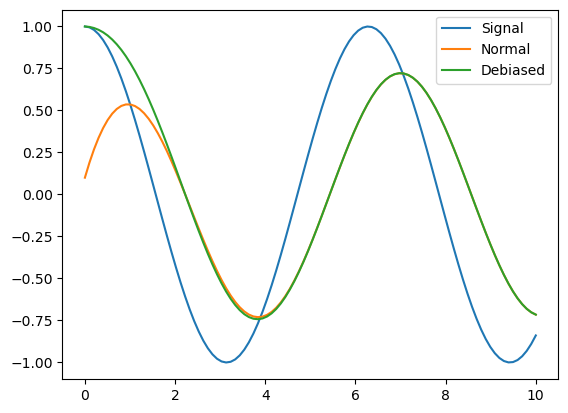

In [24]:
from k1lib.imports import *
x = torch.linspace(0, 10, 100); y = torch.cos(x) | op().item().all() | deref(); plt.plot(x, y);
a = k1lib.MovingAvg(debias=False); plt.plot(x, y | apply(lambda y: a(y).value) | deref())
a = k1lib.MovingAvg(debias=True); plt.plot(x, y | apply(lambda y: a(y).value) | deref())
plt.legend(["Signal", "Normal", "Debiased"])

In [25]:
#export
sen = "_ab_sentinel"
jitOpcodes = {"__len__": lambda x: f"len({x})",
              "__neg__": lambda x: f"(-{x})",
              "__pos__": lambda x: f"(+{x})",
              "__abs__": lambda x: f"abs({x})",
              "__invert__": lambda x: f"(~{x})",
              "__getattr__": lambda x, idx: f"getattr({x},{idx})",
              "__getitem__": lambda x, idx: f"({x}[{idx}])",
              "__round__": lambda x, o: f"round({x}, {o})",
              "__add__": lambda x, o: f"({x}+{o})",
              "__radd__": lambda x, o: f"({o}+{x})",
              "__sub__": lambda x, o: f"({x}-{o})",
              "__rsub__": lambda x, o: f"({o}-{x})",
              "__mul__": lambda x, o: f"({x}*{o})",
              "__rmul__": lambda x, o: f"({o}*{x})",
              "__matmul__": lambda x, o: f"({x}@{o})",
              "__rmatmul__": lambda x, o: f"({o}@{x})",
              "__truediv__": lambda x, o: f"({x}/{o})",
              "__rtruediv__": lambda x, o: f"({o}/{x})",
              "__floordiv__": lambda x, o: f"({x}//{o})",
              "__rfloordiv__": lambda x, o: f"({o}//{x})",
              "__mod__": lambda x, o: f"({x}%{o})",
              "__rmod__": lambda x, o: f"({o}%{x})",
              "__pow__": lambda x, o: f"({x}**{o})",
              "__rpow__": lambda x, o: f"({o}**{x})",
              "__lshift__": lambda x, o: f"({x}<<{o})",
              "__rlshift__": lambda x, o: f"({o}<<{x})",
              "__rshift__": lambda x, o: f"({x}>>{o})",
              "__rrshift__": lambda x, o: f"({o}>>{x})",
              "__and__": lambda x, o: f"({x}&{o})",
              "__rand__": lambda x, o: f"({o}&{x})",
              "__xor__": lambda x, o: f"({x}^{o})",
              "__rxor__": lambda x, o: f"({o}^{x})",
              "__or__": lambda x, o: f"({x}|{o})",
              "__ror__": lambda x, o: f"({o}|{x})",
              "__lt__": lambda x, o: f"({x}<{o})",
              "__le__": lambda x, o: f"({x}<={o})",
              "__eq__": lambda x, o: f"({x}=={o})",
              "__ne__": lambda x, o: f"({x}!={o})",
              "__gt__": lambda x, o: f"({x}>{o})",
              "__ge__": lambda x, o: f"({x}>={o})",}
opcodeAuto = AutoIncrement(prefix="_op_var_")
compareOps = {"__lt__", "__le__", "__eq__", "__ne__", "__gt__", "__ge__"}
class Absorber:
    """Creates an object that absorbes every operation done on it. Could be
useful in some scenarios::

    ab = k1lib.Absorber()
    # absorbs all operations done on the object
    abs(ab[::3].sum(dim=1))

    t = torch.randn(5, 3, 3)
    # returns transformed tensor of size [2, 3]
    ab.ab_operate(t)

Another::

    ab = Absorber()
    ab[2] = -50
    # returns [0, 1, -50, 3, 4]
    ab.ab_operate(list(range(5)))

Because this object absorbs every operation done on it, you have to be gentle with
it, as any unplanned disturbances might throw your code off. Best to create a new
one on the fly, and pass them immediately to functions, because if you're in a
notebook environment like Jupyter, it might poke at variables.

For extended code example that utilizes this, check over :class:`k1lib.cli.modifier.op`
source code."""
    def __init__(self, initDict:dict=dict()):
        """Creates a new Absorber.

:param initDict: initial variables to set, as setattr operation is normally absorbed"""
        self._ab_sentinel = True
        self._ab_steps = []
        self._ab_solidified = False
        for k, v in initDict.items(): setattr(self, k, v)
        self._ab_sentinel = False
    def ab_solidify(self):
        """Use this to not absorb ``__call__`` operations anymore and makes it
feel like a regular function (still absorbs other operations though)::

    f = op()**2
    3 | f # returns 9, but may be you don't want to pipe it in
    f.op_solidify()
    f(3)  # returns 9"""
        self._ab_sentinel = True
        self._ab_solidified = True
        self._ab_sentinel = False
        return self
    def ab_operate(self, x):
        """Special method to actually operate on an object and get the result. Not
absorbed. Example::

    # returns 6
    (op() * 2).ab_operate(3)"""
        for desc, step in self._ab_steps: x = step(x)
        return x
    def ab_fastF(self):
        """Returns a function that operates on the input (just like :meth:`ab_operate`),
but much faster, suitable for high performance tasks. Example::

    f = (k1lib.Absorber() * 2).ab_fastF()
    # returns 6
    f(3)"""
        s = self._ab_steps; l = len(s)
        try: # jit compilation
            ss = "x"; values = {}
            for (opcode, *o), *_ in s:
                if opcode == "__call__":
                    va = opcodeAuto(); vk = opcodeAuto()
                    values[va], values[vk] = o[0]
                    ss = f"({ss}(*{va}, **{vk}))"
                elif len(o) > 0:
                    varname = opcodeAuto(); v = o[0]
                    if isinstance(v, (int, float)):
                        ss = jitOpcodes[opcode](ss, v)
                    else:
                        values[varname] = v
                        ss = jitOpcodes[opcode](ss, varname)
                else: ss = jitOpcodes[opcode](ss)
            return eval(compile(f"lambda x: {ss}", "", "eval"), values)
        except Exception as e: pass
        if l == 0: return lambda x: x
        if l == 1: return s[0][1]
        if l == 2:
            a, b = s[0][1], s[1][1]
            return lambda x: b(a(x))
        if l == 3:
            a, b, c = s[0][1], s[1][1], s[2][1]
            return lambda x: c(b(a(x)))
        if l == 4:
            a, b, c, d = s[0][1], s[1][1], s[2][1], s[3][1]
            return lambda x: d(c(b(a(x))))
        if l == 5:
            a, b, c, d, e = s[0][1], s[1][1], s[2][1], s[3][1], s[4][1]
            return lambda x: e(d(c(b(a(x)))))
        return self.ab_operate
    def _ab_steps_append(self, o):
        if not self._ab_solidified:
            s = self._ab_steps
            if len(s) > 0 and s[-1][0][0] in compareOps and o[0][0] in compareOps:
                p = s.pop(); a = p[1]; b = o[1] # for 2 consecutive compare operations
                s.append([["compareOps"], lambda x: a(x) and b(x)])
            else: s.append(o)
        return self
    def __getattr__(self, idx):
        if isinstance(idx, str) and idx.startswith("_"): raise AttributeError("Getting attributes starting with underscore is prohibited. If you're using `op`, consider using `aS(lambda x: x._field)` instead.")
        return self._ab_steps_append([["__getattr__", idx], lambda x: getattr(x, idx)]);
    def __setattr__(self, k, v):
        """Only allows legit variable setting when '_ab_sentinel' is True. Absorbs
operations if it's False."""
        if k == sen: self.__dict__[k] = v
        else:
            if self.__dict__[sen]: self.__dict__[k] = v
            else:
                def f(x): setattr(x, k, v); return x
                self._ab_steps_append([["__setattr__", [k, v]], f])
                if self._ab_solidified: self.__dict__[k] = v
                return self
    def __getitem__(self, idx): return self._ab_steps_append([["__getitem__", idx], lambda x: x[idx]]);
    def __setitem__(self, k, v):
        def f(x): x[k] = v; return x
        return self._ab_steps_append([["__setitem__", [k, v]], f]);
    def __call__(self, *args, **kwargs): return self._ab_steps_append([["__call__", [args, kwargs]], lambda x: x(*args, **kwargs)]);
    def __round__(self, ndigits=0):   return self._ab_steps_append([["__round__",       ndigits], lambda x: round(x, ndigits)]);
    def __add__(self, o):       return self._ab_steps_append([["__add__",       o], lambda x: x+o ]);
    def __radd__(self, o):      return self._ab_steps_append([["__radd__",      o], lambda x: o+x ]);
    def __sub__(self, o):       return self._ab_steps_append([["__sub__",       o], lambda x: x-o ]);
    def __rsub__(self, o):      return self._ab_steps_append([["__rsub__",      o], lambda x: o-x ]);
    def __mul__(self, o):       return self._ab_steps_append([["__mul__",       o], lambda x: x*o ]);
    def __rmul__(self, o):      return self._ab_steps_append([["__rmul__",      o], lambda x: o*x ]);
    def __matmul__(self, o):    return self._ab_steps_append([["__matmul__",    o], lambda x: x@o ]);
    def __rmatmul__(self, o):   return self._ab_steps_append([["__rmatmul__",   o], lambda x: o@x ]);
    def __truediv__(self, o):   return self._ab_steps_append([["__truediv__",   o], lambda x: x/o ]);
    def __rtruediv__(self, o):  return self._ab_steps_append([["__rtruediv__",  o], lambda x: o/x ]);
    def __floordiv__(self, o):  return self._ab_steps_append([["__floordiv__",  o], lambda x: x//o]);
    def __rfloordiv__(self, o): return self._ab_steps_append([["__rfloordiv__", o], lambda x: o//x]);
    def __mod__(self, o):       return self._ab_steps_append([["__mod__",       o], lambda x: x%o ]);
    def __rmod__(self, o):      return self._ab_steps_append([["__rmod__",      o], lambda x: o%x ]);
    def __pow__(self, o):       return self._ab_steps_append([["__pow__",       o], lambda x: x**o]);
    def __rpow__(self, o):      return self._ab_steps_append([["__rpow__",      o], lambda x: o**x]);
    def __lshift__(self, o):    return self._ab_steps_append([["__lshift__",    o], lambda x: x<<o]);
    def __rlshift__(self, o):   return self._ab_steps_append([["__rlshift__",   o], lambda x: o<<x]);
    def __rshift__(self, o):    return self._ab_steps_append([["__rshift__",    o], lambda x: x>>o]);
    def __rrshift__(self, o):   return self._ab_steps_append([["__rrshift__",   o], lambda x: o>>x]);
    def __and__(self, o):       return self._ab_steps_append([["__and__",       o], lambda x: x&o ]);
    def __rand__(self, o):      return self._ab_steps_append([["__rand__",      o], lambda x: o&x ]);
    def __xor__(self, o):       return self._ab_steps_append([["__xor__",       o], lambda x: x^o ]);
    def __rxor__(self, o):      return self._ab_steps_append([["__rxor__",      o], lambda x: o^x ]);
    def __or__(self, o):        return self._ab_steps_append([["__or__",        o], lambda x: x|o ]);
    def __ror__(self, o):       return self._ab_steps_append([["__ror__",       o], lambda x: o|x ]);
    def __lt__(self, o):        return self._ab_steps_append([["__lt__",        o], lambda x: x<o ]);
    def __le__(self, o):        return self._ab_steps_append([["__le__",        o], lambda x: x<=o]);
    def __eq__(self, o):        return self._ab_steps_append([["__eq__",        o], lambda x: x==o]);
    def __ne__(self, o):        return self._ab_steps_append([["__ne__",        o], lambda x: x!=o]);
    def __gt__(self, o):        return self._ab_steps_append([["__gt__",        o], lambda x: x>o ]);
    def __ge__(self, o):        return self._ab_steps_append([["__ge__",        o], lambda x: x>=o]);
    def __neg__(self):    return self._ab_steps_append([["__neg__"],    lambda x: -x      ]);
    def __pos__(self):    return self._ab_steps_append([["__pos__"],    lambda x: +x      ]);
    def __abs__(self):    return self._ab_steps_append([["__abs__"],    lambda x: abs(x)  ]);
    def __invert__(self): return self._ab_steps_append([["__invert__"], lambda x: ~x      ]);
    def ab_int(self):
        """Replacement for ``int(ab)``, as that requires returning an actual :class:`int`."""
        return self._ab_steps_append([["__int__"],    lambda x: int(x)  ]);
    def __int__(self):    return self.int()
    def ab_float(self):
        """Replacement for ``float(ab)``, as that requires returning an actual :class:`float`."""
        return self._ab_steps_append([["__float__"],  lambda x: float(x)]);
    def __float__(self):  return self.float()
    def ab_str(self):
        """Replacement for ``str(ab)``, as that requires returning an actual :class:`str`."""
        return self._ab_steps_append([["__str__"],    lambda x: str(x)  ]);
    def ab_len(self):
        """Replacement for ``len(ab)``, as that requires returning an actual :class:`int`."""
        return self._ab_steps_append([["__len__"],    lambda x: len(x)  ]);
    def ab_contains(self, key):
        """Replacement for ``key in ab``, as that requires returning an actual :class:`int`."""
        return self._ab_steps_append([["__contains__", key], lambda x: key in x]);

In [26]:
ab = abs(Absorber()[::3].sum(dim=1))
assert ab.ab_operate(torch.randn(5, 3, 3)).shape == torch.Size([2, 3])
ab = Absorber(); ab.value = 3
assert ab.ab_operate(AutoIncrement()).value == 3
ab = Absorber(); ab[2] = -50
assert ab.ab_operate(list(range(5))) == [0, 1, -50, 3, 4]
assert (Absorber() * 2).ab_fastF()(3) == 6
assert (Absorber() * 2).ab_operate(3) == 6

In [27]:
#export
sep = "\u200b" # weird separator, guaranteed (mostly) to not appear anywhere in the
# settings, so that I can pretty print it
class Settings:
    def __init__(self, **kwargs):
        """Creates a new settings object. Basically fancy version of :class:`dict`.
Example::

    s = k1lib.Settings(a=3, b="42")
    s.c = k1lib.Settings(d=8)
    
    s.a # returns 3
    s.b # returns "42"
    s.c.d # returns 8
    print(s) # prints nested settings nicely"""
        self._setattr_sentinel = True
        for k, v in kwargs.items(): setattr(self, k, v)
        self._docs = dict(); self._cbs = dict()
        self._setattr_sentinel = False
    @contextlib.contextmanager
    def context(self, **kwargs):
        """Context manager to temporarily modify some settings. Applies
to all sub-settings. Example::

    s = k1lib.Settings(a=3, b="42", c=k1lib.Settings(d=8))
    with s.context(a=4):
        s.c.d = 20
        s.a # returns 4
        s.c.d # returns 20
    s.a # returns 3
    s.c.d # returns 8"""
        oldValues = dict(self.__dict__); err = None
        for k in kwargs.keys():
            if k not in oldValues:
                raise RuntimeError(f"'{k}' settings not found!")
        try:
            with contextlib.ExitStack() as stack:
                for _, sub in self._subSettings():
                    stack.enter_context(sub.context())
                for k, v in kwargs.items(): setattr(self, k, v)
                yield
        finally:
            for k, v in oldValues.items(): setattr(self, k, v)
    def add(self, k:str, v:Any, docs:str="", cb:Callable[["Settings", Any], None]=None) -> "Settings":
        """Long way to add a variable. Advantage of this is that you can slip in extra
documentation for the variable. Example::

    s = k1lib.Settings()
    s.add("a", 3, "some docs")
    print(s) # displays the extra docs

:param cb: callback that takes in (settings, new value) if any property changes"""
        setattr(self, k, v); self._docs[k] = docs
        self._cbs[k] = cb; return self
    def _docsOf(self, k:str):
        return f"{self._docs[k]}" if k in self._docs else ""
    def _subSettings(self) -> List[Tuple[str, "Settings"]]:
        return [(k, v) for k, v in self.__dict__.items() if isinstance(v, Settings) and not k.startswith("_")]
    def _simpleSettings(self) -> List[Tuple[str, Any]]:
        return [(k, v) for k, v in self.__dict__.items() if not isinstance(v, Settings) and not k.startswith("_")]
    def __setattr__(self, k, v):
        self.__dict__[k] = v
        if k != "_setattr_sentinel" and not self._setattr_sentinel:
            if k in self._cbs and self._cbs[k] is not None: self._cbs[k](self, v)
    def __repr__(self):
        """``includeDocs`` mainly used internally when generating docs in sphinx."""
        ks = list(k for k in self.__dict__ if not k.startswith("_"))
        kSpace = max([1, *(ks | k1lib.cli.shape(0).all())]); s = "Settings:\n"
        for k, v in self._simpleSettings():
            s += f"- {k.ljust(kSpace)} = {k1lib.limitChars(str(v), settings.displayCutoff)}{sep}{self._docsOf(k)}\n"
        for k, v in self._subSettings():
            sub = v.__repr__().split("\n")[1:-1] | k1lib.cli.tab("  ") | k1lib.cli.join("\n")
            s += f"- {k.ljust(kSpace)} = <Settings>{sep}{self._docsOf(k)}\n" + sub + "\n"
        return s.split("\n") | k1lib.cli.op().split(sep).all() | k1lib.cli.pretty(sep) | k1lib.cli.join("\n")
_settings = Settings().add("test", Settings().add("bio", True, "whether to test bioinformatics clis that involve strange command line tools like samtools and bwa"))
_settings.add("packages", Settings(), "which package is available to use?")
settings = Settings().add("displayCutoff", 50, "cutoff length when displaying a Settings object")
settings.add("svgScale", 0.7, "default svg scales for clis that displays graphviz graphs")
def _cb_wd(s, p):
    if p != None: p = os.path.abspath(os.path.expanduser(p)); _oschdir(p)
    s.__dict__["wd"] = p
def oschdir(path): settings.wd = path
_oschdir = os.chdir; os.chdir = oschdir; os.chdir.__doc__ = _oschdir.__doc__
settings.add("wd", os.getcwd(), "default working directory, will get from `os.getcwd()`. Will update using `os.chdir()` automatically when changed", _cb_wd)
settings.add("cancelRun_newLine", True, "whether to add a new line character at the end of the cancel run/epoch/batch message")
or_patch = Settings()\
    .add("numpy", True, "whether to patch numpy arrays")\
    .add("dict", True, "whether to patch Python dict keys and items")\
    .add("pandas", True, "whether to patch pandas series")
startup = Settings().add("init_ray", True, "whether to connect to ray's cluster accessible locally automatically").add("or_patch", or_patch, "whether to patch __or__() method for several C-extension datatypes (numpy array, pandas data frame/series, etc). This would make cli operations with them a lot more pleasant, but might cause strange bugs. Haven't met them myself though")
settings.add("startup", startup, "these settings have to be applied like this: `import k1lib; k1lib.settings.startup.or_patch = False; from k1lib.imports import *` to ensure that the values are set")
settings.add("pushNotificationKey", os.getenv("k1lib_pushNotificationKey", None), "API key for `k1lib.pushNotification()`. See docs of that for more info")

Settings:                                                     
- displayCutoff       = 50                                    ​cutoff length when displaying a Settings object                                                                                                                                                                                                  
- svgScale            = 0.7                                   ​default svg scales for clis that displays graphviz graphs                                                                                                                                                                                        
- wd                  = /home/kelvin/repos/labs/k1lib/k1lib   ​default working directory, will get from `os.getcwd()`. Will update using `os.chdir()` automatically when changed                                                                                                                                
- cancelRun_newLine   

In [28]:
with k1lib.captureStdout() as out: print(Settings(ab=4, b="yh", cli=Settings(oboFile="3")))
assert len(out()) > 0
s = Settings(a=3, b="42"); s.c = Settings(d=8)
assert s.a == 3; assert s.b == "42"; assert s.c.d == 8
s = Settings(a=3, b="42", c=Settings(d=8))
with s.context(a=4):
    s.c.d = 20; assert s.a == 4; assert s.c.d == 20
assert s.a == 3; assert s.c.d == 8
Settings().add("a", 3, "some docs")
try: # setting bogus settings in context
    with settings.context(a=4): pass
    assert 0
except RuntimeError: pass

In [29]:
#export
def sign(v): return 1 if v > 0 else -1
def roundOff(a, b):
    m = (a + b) / 2
    return m
    dec = math.log10(abs(a-m)+1e-7) # decimal place
    factor = 10**(sign(dec) * math.floor(abs(dec)+1e-7)+1)
    return factor*round(m/factor)
def toPrecision(num, sig=1):
    if num == 0: return 0
    s = sign(num); num = abs(num)
    fac = 10**(-math.floor(math.log10(num))+sig-1)
    return s*round(num*fac)/fac
def niceUS(mean, std):
    if std < 1e-12: return mean, std
    pres = 2 if std/10**math.floor(math.log10(std)) < 2 else 1
    std = toPrecision(std, pres)
    fac = 10**(-math.floor(math.log10(std))+pres-1)
    return round(mean*fac)/fac, std
def removeOutliers(t, fraction=0.01):
    b = int(len(t)*fraction/2)
    return t.sort().values[b:-b]

In [30]:
roundOff(523208, 523400), roundOff(4.8778, 4.8779), roundOff(4.8998, 4.8999), roundOff(1.4096, 1.4162)
assert toPrecision(0.7717, 2) == 0.77
assert toPrecision(12345, 3) == 12300
assert niceUS(14.4417, 0.7717) == (14.4, 0.8)

In [31]:
#export
def _US(v): return [*v] if isinstance(v, UValue) else [v, 0]
if hasTorch:
    class UValue:
        _unit = torch.randn(2, 5, 100000)
        def __init__(self, mean=0, std=1):
            """Creates a new "uncertain value", which has a mean and a standard
deviation. You can then do math operations on them as normal, and the
propagation errors will be automatically calculated for you. Make sure to
run the calculation multiple times as the mean and std values fluctuates by
a little run-by-run. Example::

    # returns UValue(mean=4.7117, std=3.4736) object
    abs(k1lib.UValue() * 5 + 3)

You can also instantiate from an existing list/numpy array/pytorch tensor::

    # returns UValue(mean=24.5, std=14.58) object
    k1lib.UValue.fromSeries(range(50))

You can also do arbitrary complex math operations::

    # returns UValue(mean=0.5544, std=0.4871)
    (20 + k1lib.UValue()).f(np.sin)
    # same as above, but takes longer to run!
    (20 + k1lib.UValue()).f(math.sin)

I suggest you to make your arbitrary function out of numpy's operations,
as those are a fair bit faster than regular Python.

If you have a list of :class:`UValue`, and want to plot them with error
bars, then you can do something like this::

    x = np.linspace(0, 6)
    y = list(np.sin(x)*10) | apply(k1lib.UValue) | toList()
    plt.errorbar(x, *(y | transpose()));

There are several caveats however:

.. note::

    First is the problem of theoretically vs actually sample a
    distribution. Let's see an example::

        # returns theoretical value UValue(mean=8000.0, std=1200.0) -> 8000.0 ± 1200.0
        k1lib.UValue(20) ** 3
        # prints out actual mean and std value of (8064.1030, 1204.3529)
        a = k1lib.UValue(20).sample() ** 3
        print(a.mean(), a.std())

    So far so good. However, let's create some uncertainty in "3"::

        # returns theoretical value UValue(mean=8000.0, std=23996.0) -> 10000.0 ± 20000.0
        k1lib.UValue(20) ** k1lib.UValue(3)
        # prints out actual mean and std value of (815302.8750, 27068828.), but is very unstable and changes a lot
        a = k1lib.UValue(20).sample() ** k1lib.UValue(3).sample()
        print(a.mean(), a.std())

    Woah, what happens here? The actual mean and std values are
    completely different from the theoretical values. This is
    mainly due to UValue(3) has some outlier values large enough
    to boost the result up multiple times. Even removing 1% of
    values on either end of the spectrum does not quite work. So,
    becareful to interpret these uncertainty values, and in some
    case the theoretical estimates from math are actually very
    unstable and will not be observed in real life.

.. note::

    Then there's the problem of each complex operation, say ``(v*2+3)/5``
    will be done step by step, meaning ``a=v*2`` mean and std will be
    calculated first, then ignoring the calculated sample values and just
    go with the mean and std, sample a bunch of values from there and calculate
    ``a+3`` mean and std. Rinse and repeat. This means that these 2 statements
    may differ by a lot::

        # prints out (0.15867302766786406, 0.12413313456900205)
        x = np.linspace(-3, 3, 1000); sq = (abs(x)-0.5)**2; y = sq*np.exp(-sq)
        print(y.mean(), y.std())

        # returns UValue(mean=0.081577, std=0.32757) -> 0.1 ± 0.3
        x = k1lib.UValue(0, 1); sq = (abs(x)-0.5)**2; y = sq*(-sq).f(np.exp)

    Why this weird function? It converts from a single nice hump into multiple
    complex humps. Anyway, this serves to demonstrate that the result from the
    ``calculate -> get mean, std -> sample from new distribution -> calculate``
    process might be different from just calculating from start to end and then
    get the mean and std.

.. note::

    Lastly, you might have problems when using the same UValue multiple times in
    an expression::

        a = UValue(10, 1)
        a * 2 # has mean 20, std 2
        a + a # has mean 20, std 1.4"""
            if isinstance(mean, torch.Tensor): mean = mean.item()
            if isinstance(std, torch.Tensor): std = std.item()
            self.mean = mean; self.std = std
        @staticmethod
        def _sample(mean, std, n=None, _class=0):
            t = UValue._unit[_class, random.randint(0, 4)]
            if n is not None: t = t[:n]
            return t * std + mean
        def sample(self, n=100, _class=0):
            """Gets a sample :class:`np.ndarray` representative of this
    uncertain value. Example::

        # returns tensor([-5.1095,  3.3117, -2.5759,  ..., -2.5810, -1.8131,  1.8339])
        (k1lib.UValue() * 5).sample()"""
            return UValue._sample(*self, n, _class)
        @staticmethod
        def fromSeries(series, unbiased=True):
            """Creates a :class:`UValue` from a bunch of numbers

:param series: can be a list of numbers, numpy array or PyTorch tensor
:param unbiased: if True, Bessel’s correction will be used"""
            if isinstance(series, np.ndarray):
                series = torch.tensor(series)
            elif not isinstance(series, torch.Tensor):
                series = torch.tensor(list(series))
            series = series * 1.0
            return UValue(series.mean(), series.std(unbiased=unbiased))
        @staticmethod
        def fromBounds(min_, max_):
            """Creates a :class:`UValue` from min and max values.
Example::

    # returns UValue(mean=2.5, std=0.5)
    k1lib.UValue.fromBounds(2, 3)"""
            mid = (min_ + max_)/2
            return k1lib.UValue(mid, abs(max_-mid))
        def __iter__(self): yield self.mean; yield self.std
        def _niceValue(self, v, _class=0):
            if isinstance(v, UValue): return [UValue._sample(*v, None, _class), UValue._sample(*v, None, _class)]
            return [UValue._sample(v, 0, None, _class), UValue._sample(v, 0, None, _class)]
        def _postProcess(self, c1, c2):
            if c1.hasNan() or c2.hasNan():
                warnings.warn("Calculations has NaN values. They will be replaced with 0, which can affect accuracy of mean and std calculations")
                c1.clearNan(); c2.clearNan()
            c1 = removeOutliers(c1); c2 = removeOutliers(c2);
            return UValue(roundOff(c1.mean().item(), c2.mean().item()), roundOff(c1.std().item(), c2.std().item()))
        @property
        def exact(self):
            """Whether this UValue is exact or not"""
            return self.std == 0
        @staticmethod
        def _isValueExact(v):
            if isinstance(v, UValue): return v.exact
            try: len(v); return False
            except: return True
        @staticmethod
        def _value(v): # gets mean value
            if isinstance(v, UValue): return v.mean
            try: len(v); raise RuntimeError("Can't convert a series into an exact value")
            except: return v
        def test(self, v):
            """Returns how many sigma a particular value is."""
            return (v-self.mean)/self.std
        def f(self, func):
            """Covered in :meth:`__init__` docs"""
            if self.exact: return UValue(func(self.mean), 0)
            f = func; a1, a2 = self._niceValue(self)
            try: return self._postProcess(f(a1), f(a2))
            except:
                f = lambda xs: torch.tensor([func(x) for x in xs[:10000]])
                return self._postProcess(f(a1), f(a2))
        def bounds(self):
            """Returns (mean-std, mean+std)"""
            return self.mean - self.std, self.mean + self.std
        def _op2(self, func, a, b):
            if UValue._isValueExact(a) and UValue._isValueExact(b):
                return UValue(func(UValue._value(a), UValue._value(b)), 0)
            f = func; a1, a2 = self._niceValue(a, 0); b1, b2 = self._niceValue(b, 1)
            try: return self._postProcess(f(a1, b1), f(a2, b2))
            except:
                f = lambda xs, ys: torch.tensor([func(x, y).item() for x, y in zip(xs[:10000], ys[:10000])])
                return self._postProcess(f(a1, b1), f(a2, b2))
        @staticmethod
        def combine(*values, samples=1000):
            """Combines multiple UValues into 1.
Example::

    a = k1lib.UValue(5, 1)
    b = k1lib.UValue(7, 1)
    # both returns 6.0 ± 1.4
    k1lib.UValue.combine(a, b)
    [a, b] | k1lib.UValue.combine()

This will sample each UValue by default 1000 times, put them into a
single series and get a UValue from that. Why not just take the
average instead? Because the standard deviation will be less, and
will not actually reflect the action of combining UValues together::

    # returns 6.0 ± 0.7, which is narrower than expected
    (a + b) / 2"""
            if len(values) == 0: return ~k1lib.cli.aS(UValue.combine)
            return UValue.fromSeries(torch.cat([v.sample(1000) for v in values]))
        def __add__(self, v):
            m1, s1 = _US(self); m2, s2 = _US(v)
            return UValue(m1+m2, math.sqrt(s1**2 + s2**2))
            return self._op2(lambda a, b: a+b, v, self) # representative of how this would work stochastically
        def __radd__(self, v):
            m1, s1 = _US(self); m2, s2 = _US(v)
            return UValue(m1+m2, math.sqrt(s1**2 + s2**2))
        def __sub__(self, v):
            m1, s1 = _US(self); m2, s2 = _US(v)
            return UValue(m1-m2, math.sqrt(s1**2 + s2**2))
        def __rsub__(self, v):
            m1, s1 = _US(self); m2, s2 = _US(v)
            return UValue(m2-m1, math.sqrt(s1**2 + s2**2))
        def __mul__(self, v):
            m1, s1 = _US(self); m2, s2 = _US(v)
            return UValue(m1*m2, math.sqrt(m2**2*s1**2 + m1**2*s2**2))
        def __rmul__(self, v):
            m1, s1 = _US(self); m2, s2 = _US(v)
            return UValue(m1*m2, math.sqrt(m2**2*s1**2 + m1**2*s2**2))
        def __truediv__(self, v):
            m1, s1 = _US(self); m2, s2 = _US(v)
            return UValue(m1/m2, math.sqrt(1/m2**2*s1**2 + m1**2/m2**4*s2**2))
        def __rtruediv__(self, v):
            m1, s1 = _US(v); m2, s2 = _US(self)
            return UValue(m1/m2, math.sqrt(1/m2**2*s1**2 + m1**2/m2**4*s2**2))
        def __pow__(self, v):
            m1, s1 = _US(self); m2, s2 = _US(v); m = m1**m2
            return UValue(m, math.sqrt((m2*m/m1)**2*s1**2 + (math.log(m1)*m)**2*s2**2))
        def __rpow__(self, v):
            m1, s1 = _US(v); m2, s2 = _US(self); m = m1**m2
            return UValue(m, math.sqrt((m2*m/m1)**2*s1**2 + (math.log(m1)*m)**2*s2**2))
        def __abs__(self): return self.f(lambda a: abs(a)) # can't convert to pure math that makes sense
        def __neg__(self): return 0 - self
        def __repr__(self):
            mean, std = niceUS(self.mean, self.std)
            return f"UValue(mean={toPrecision(self.mean, 5)}, std={toPrecision(self.std, 5)}) -> {mean} ± {std}"
        def plot(self, name=None):
            """Quickly plots a histogram of the distribution.
Possible to plot multiple histograms in 1 plot."""
            plt.hist(self.sample(None).numpy(), bins=100, alpha=0.7, label=name)
            if name != None: plt.legend()
else:
    class UValue:
        def __init__(self):
            return NotImplemented

In [32]:
assert isinstance(abs(UValue() * 5 + 3), UValue)
assert UValue.fromSeries(range(50)).__repr__() == "UValue(mean=24.5, std=14.577) -> 24.0 ± 15.0"
assert UValue(4, 0).__repr__() == "UValue(mean=4.0, std=0) -> 4 ± 0"
assert UValue.fromBounds(2, 3).__repr__() == "UValue(mean=2.5, std=0.5) -> 2.5 ± 0.5"
assert isinstance((20 + UValue()).f(np.sin), UValue)
assert isinstance((20 + UValue()).f(math.sin), UValue)
assert isinstance((UValue() * 5).sample(), torch.Tensor)
a = UValue(10, 1)
assert (a * 2).std == 2
assert abs((a + a).std - math.sqrt(2)) < 1e-5
a = UValue(5, 1); b = UValue(7, 1)
UValue.combine(a, b); [a, b] | UValue.combine()

UValue(mean=6.0185, std=1.426) -> 6.0 ± 1.4

In [42]:
#export
class ConstantPad:
    def __init__(self, left=False):
        """Adds constant amount of padding to strings.
Example::

    p = k1.ConstantPad()
    p("123")    # returns "123"
    p("23")     # returns " 23"
    "12345" | p # returns "12345", can pipe it in too, but is not strictly a cli tool
    p("123")    # returns "  123"

Basically, this is useful in situations when you're printing a table or status bar and
needs relatively constant width but you don't know what's the desired width at the start.

As you normally use a bunch of these in groups, there's a convenience function for
that too::

    p1, p2 = k1.ConstantPad.multi(2)

:param left: whether to align left or not"""
        self.left = left; self.length = 0
    def __call__(self, s):
        self.length = max(self.length, len(s))
        return s.ljust(self.length) if self.left else s.rjust(self.length)
    def __ror__(self, s): return self.__call__(s)
    @staticmethod
    def multi(n, *args, **kwargs): return [ConstantPad(*args, **kwargs) for i in range(n)]

In [44]:
p = ConstantPad()
assert p("123") == "123"; assert p("23") == " 23"
assert "12345" | p == "12345"; assert p("123") == "  123"
assert len(ConstantPad.multi(2)) == 2

In [27]:
!../export.py _baseClasses

Current dir: /home/kelvin/repos/labs/k1lib, /home/kelvin/repos/labs/k1lib/k1lib/../export.py
rm: cannot remove '__pycache__': No such file or directory
Found existing installation: k1lib 1.3.9.4
Uninstalling k1lib-1.3.9.4:
  Successfully uninstalled k1lib-1.3.9.4
running install
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
/home/kelvin/anaconda3/envs/ray2/lib/python3.9/site-packages/setuptools/command/easy_install.py:144: EasyInstallDeprecationWarning: easy_install command is deprecated. Use build and pip and other standards-based tools.
  warnings.warn(
running bdist_egg
running egg_info
creating k1lib.egg-info
writing k1lib.egg-info/PKG-INFO
writing dependency_links to k1lib.egg-info/dependency_links.txt
writing requirements to k1lib.egg-info/requires.txt
writing top-level names to k1lib.egg-info/top_level.